# Store Sales - Time Series Forecasting

## Introduction

This project is aiming to predict store sales from past data.

The dataset contains 6 different files, that must be combined in some way to extract features for prediction.

Dataset information: https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

### Pre Processing

In [2]:
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')

stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')
holidays_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')

In [3]:
train_df['date'] = pd.to_datetime(train_df['date'])

test_df['date'] = pd.to_datetime(test_df['date'])

transactions_df['date']=pd.to_datetime(transactions_df['date'])

oil_df['date'] = pd.to_datetime(oil_df['date'])

holidays_df['date'] = pd.to_datetime(holidays_df['date'])

In [6]:
train_df['day_of_week'] = train_df['date'].dt.dayofweek

train_df['month'] = train_df['date'].dt.month

train_df['year'] = train_df['date'].dt.year

In [4]:
test_df['day_of_week'] = test_df['date'].dt.dayofweek

test_df['month'] = test_df['date'].dt.month

test_df['year'] = test_df['date'].dt.year

In [7]:
# Concatenate train and test dataset for pre precessing once

train_df['is_train'] = 1

test_df['is_train'] = 0


test_df['sales'] = np.nan


combined_df = pd.concat([train_df, test_df], sort=False)


combined_df = combined_df.sort_values(['store_nbr', 'family', 'date'])


print("Combined dataset shape:", combined_df.shape)

Combined dataset shape: (3029400, 10)


In [8]:
combined_df

,id,date,store_nbr,family,sales,onpromotion,is_train,day_of_week,month,year
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,2013
1782,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,1,2,1,2013
3564,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,1,3,1,2013
5346,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,1,4,1,2013
7128,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1,5,1,2013
...,...,...,...,...,...,...,...,...,...,...
21251,3022139,2017-08-27,54,SEAFOOD,NaN,0,0,6,8,2017
23033,3023921,2017-08-28,54,SEAFOOD,NaN,0,0,0,8,2017
24815,3025703,2017-08-29,54,SEAFOOD,NaN,0,0,1,8,2017
26597,3027485,2017-08-30,54,SEAFOOD,NaN,0,0,2,8,2017


In [9]:
# Merge transactions_df to combined_df

combined_df = pd.merge(combined_df, transactions_df, on=['store_nbr', 'date'], how='left')

In [10]:
combined_df

,id,date,store_nbr,family,sales,onpromotion,is_train,day_of_week,month,year,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,2013,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,1,2,1,2013,2111.0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,1,3,1,2013,1833.0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,1,4,1,2013,1863.0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1,5,1,2013,1509.0
...,...,...,...,...,...,...,...,...,...,...,...
3029395,3022139,2017-08-27,54,SEAFOOD,NaN,0,0,6,8,2017,NaN
3029396,3023921,2017-08-28,54,SEAFOOD,NaN,0,0,0,8,2017,NaN
3029397,3025703,2017-08-29,54,SEAFOOD,NaN,0,0,1,8,2017,NaN
3029398,3027485,2017-08-30,54,SEAFOOD,NaN,0,0,2,8,2017,NaN


In [11]:
median_transactions = combined_df[combined_df['is_train'] == 1]['transactions'].median()

combined_df['transactions'].fillna(median_transactions, inplace=True)

/tmp/ipykernel_30/1968287981.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['transactions'].fillna(median_transactions, inplace=True)


In [12]:
combined_df

,id,date,store_nbr,family,sales,onpromotion,is_train,day_of_week,month,year,transactions
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,2013,1393.0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,1,2,1,2013,2111.0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,1,3,1,2013,1833.0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,1,4,1,2013,1863.0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1,5,1,2013,1509.0
...,...,...,...,...,...,...,...,...,...,...,...
3029395,3022139,2017-08-27,54,SEAFOOD,NaN,0,0,6,8,2017,1393.0
3029396,3023921,2017-08-28,54,SEAFOOD,NaN,0,0,0,8,2017,1393.0
3029397,3025703,2017-08-29,54,SEAFOOD,NaN,0,0,1,8,2017,1393.0
3029398,3027485,2017-08-30,54,SEAFOOD,NaN,0,0,2,8,2017,1393.0


In [13]:
oil_df.fillna({'dcoilwtico':oil_df['dcoilwtico'].median()}, inplace=True)

In [14]:
# Merge oil_df to combined_df

combined_df = pd.merge(combined_df, oil_df[['date', 'dcoilwtico']], on='date', how='left')

combined_df['dcoilwtico'].fillna(method='ffill', inplace=True)

/tmp/ipykernel_30/4179499330.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['dcoilwtico'].fillna(method='ffill', inplace=True)
/tmp/ipykernel_30/4179499330.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined_df['dcoilwtico'].fillna(method='ffill', inplace=True)


In [15]:
combined_df

,id,date,store_nbr,family,sales,onpromotion,is_train,day_of_week,month,year,transactions,dcoilwtico
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,2013,1393.0,53.19
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,1,2,1,2013,2111.0,93.14
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,1,3,1,2013,1833.0,92.97
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,1,4,1,2013,1863.0,93.12
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1,5,1,2013,1509.0,93.12
...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3022139,2017-08-27,54,SEAFOOD,NaN,0,0,6,8,2017,1393.0,47.65
3029396,3023921,2017-08-28,54,SEAFOOD,NaN,0,0,0,8,2017,1393.0,46.40
3029397,3025703,2017-08-29,54,SEAFOOD,NaN,0,0,1,8,2017,1393.0,46.46
3029398,3027485,2017-08-30,54,SEAFOOD,NaN,0,0,2,8,2017,1393.0,45.96


#### Create Lag Features

Creating lag feature is a popular technique used in Time series Forecasting problem.

Lag_n of a row here (a row belongs to store B, product family A on date C), is the sales value of product family A in store B on date C - n

It means that I will use the value of the time series from the previous n days as a feature to predict the current value.

Lag features can create static data about time series for every records. This attribute is neccesary for training model that I will use later.

In [16]:
# group by and then shift here means that sales_lag_1 of row n of store A, product family B will get the value of row n-1 of same store and product family 
# (which is the data of that store and product in previous date)

combined_df['sales_lag_1'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(1) 

combined_df['sales_lag_7'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(7)

combined_df['sales_roll_mean_7'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).mean()

combined_df['sales_roll_std_7'] = combined_df.groupby(['store_nbr', 'family'])['sales'].shift(1).rolling(window=7).std()

combined_df['promo_last_7'] = combined_df.groupby(['store_nbr', 'family'])['onpromotion'].shift(1).rolling(window=7).sum()


# records that does not have lag value must be replace with 0 for that lag value

lag_features = ['sales_lag_1', 'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7']

for feature in lag_features:

    if feature in combined_df.columns:

        combined_df[feature].fillna(0, inplace=True)


combined_df['promo_last_7'].fillna(0, inplace=True)

/tmp/ipykernel_30/1831409697.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df[feature].fillna(0, inplace=True)
/tmp/ipykernel_30/1831409697.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 

In [17]:
combined_df['date'] = pd.to_datetime(combined_df['date'])

combined_df['day_of_week'] = combined_df['date'].dt.dayofweek

combined_df['month'] = combined_df['date'].dt.month

combined_df['year'] = combined_df['date'].dt.year

In [18]:
combined_df

,id,date,store_nbr,family,sales,onpromotion,is_train,day_of_week,month,year,transactions,dcoilwtico,sales_lag_1,sales_lag_7,sales_roll_mean_7,sales_roll_std_7,promo_last_7
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0,1,1,1,2013,1393.0,53.19,0.0,0.0,0.0,0.0,0.0
1,1782,2013-01-02,1,AUTOMOTIVE,2.0,0,1,2,1,2013,2111.0,93.14,0.0,0.0,0.0,0.0,0.0
2,3564,2013-01-03,1,AUTOMOTIVE,3.0,0,1,3,1,2013,1833.0,92.97,2.0,0.0,0.0,0.0,0.0
3,5346,2013-01-04,1,AUTOMOTIVE,3.0,0,1,4,1,2013,1863.0,93.12,3.0,0.0,0.0,0.0,0.0
4,7128,2013-01-05,1,AUTOMOTIVE,5.0,0,1,5,1,2013,1509.0,93.12,3.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,3022139,2017-08-27,54,SEAFOOD,NaN,0,0,6,8,2017,1393.0,47.65,0.0,0.0,0.0,0.0,1.0
3029396,3023921,2017-08-28,54,SEAFOOD,NaN,0,0,0,8,2017,1393.0,46.40,0.0,0.0,0.0,0.0,1.0
3029397,3025703,2017-08-29,54,SEAFOOD,NaN,0,0,1,8,2017,1393.0,46.46,0.0,0.0,0.0,0.0,1.0
3029398,3027485,2017-08-30,54,SEAFOOD,NaN,0,0,2,8,2017,1393.0,45.96,0.0,0.0,0.0,0.0,1.0


In [19]:

# Split back into train and test based on 'is_train' flag

train_processed = combined_df[combined_df['is_train'] == 1].copy()

test_processed = combined_df[combined_df['is_train'] == 0].copy()


# Drop 'is_train' flag

train_processed.drop(['is_train'], axis=1, inplace=True)

test_processed.drop(['is_train'], axis=1, inplace=True)


print("Train shape:", train_processed.shape)

print("Test shape:", test_processed.shape)

Train shape: (3000888, 16)
Test shape: (28512, 16)


In [20]:
train_processed.isna().sum()

id                   0
date                 0
store_nbr            0
family               0
sales                0
onpromotion          0
day_of_week          0
month                0
year                 0
transactions         0
dcoilwtico           0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64

In [21]:
# Handle categorical columns 

encoder = LabelEncoder()

categorical_col = 'family'

train_processed[categorical_col] = encoder.fit_transform(train_processed[categorical_col])

test_processed[categorical_col] = encoder.transform(test_processed[categorical_col])

In [22]:
### Scale Numerical Features

numerical_features = ['onpromotion', 'dcoilwtico', 'transactions', 'sales_lag_1',

                      'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7', 'promo_last_7']

scaler = StandardScaler() # Standard Scaler will scale to get mean = 0 and std = 1

train_processed[numerical_features] = scaler.fit_transform(train_processed[numerical_features])

test_processed[numerical_features] = scaler.transform(test_processed[numerical_features])

In [23]:
train_processed

,id,date,store_nbr,family,sales,onpromotion,day_of_week,month,year,transactions,dcoilwtico,sales_lag_1,sales_lag_7,sales_roll_mean_7,sales_roll_std_7,promo_last_7
0,0,2013-01-01,1,0,0.0,-0.213012,1,1,2013,-0.298806,-0.562396,-0.324514,-0.323692,-0.340659,-0.299232,-0.293134
1,1782,2013-01-02,1,0,2.0,-0.213012,2,1,2013,0.475996,1.012905,-0.324514,-0.323692,-0.340659,-0.299232,-0.293134
2,3564,2013-01-03,1,0,3.0,-0.213012,3,1,2013,0.176003,1.006202,-0.322699,-0.323692,-0.340659,-0.299232,-0.293134
3,5346,2013-01-04,1,0,3.0,-0.213012,4,1,2013,0.208377,1.012116,-0.321791,-0.323692,-0.340659,-0.299232,-0.293134
4,7128,2013-01-05,1,0,5.0,-0.213012,5,1,2013,-0.173629,1.012116,-0.321791,-0.323692,-0.340659,-0.299232,-0.293134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029379,2993627,2017-08-11,54,32,0.0,-0.213012,4,8,2017,-0.973251,-0.735107,-0.322699,-0.323692,-0.337792,-0.287089,-0.276963
3029380,2995409,2017-08-12,54,32,1.0,-0.131172,5,8,2017,-0.827571,-0.735107,-0.324514,-0.320964,-0.337792,-0.287089,-0.276963
3029381,2997191,2017-08-13,54,32,2.0,-0.213012,6,8,2017,-0.664625,-0.735107,-0.323607,-0.323692,-0.338065,-0.286902,-0.276963
3029382,2998973,2017-08-14,54,32,0.0,-0.213012,0,8,2017,-0.919295,-0.783214,-0.322699,-0.323692,-0.337792,-0.287312,-0.276963


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


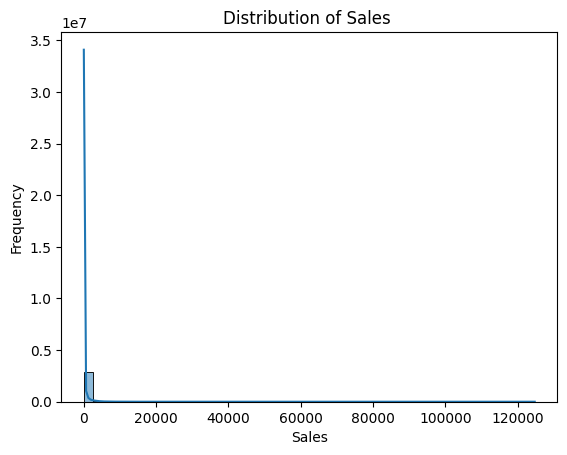

In [24]:
# Plot histogram

sns.histplot(train_processed['sales'], bins=50, kde=True)

plt.title('Distribution of Sales ')

plt.xlabel('Sales')

plt.ylabel('Frequency')

plt.show()

Note:

- There are too many records that have sales = 0. I think that some records are invalid because the stores may not have opened yet or have been closed at that time

- I will remove them by check if it is not holiday but sales = 0 => remove that record

In [25]:
holidays_df['date'] = pd.to_datetime(holidays_df['date'])

train_processed['date'] = pd.to_datetime(train_processed['date'])


train_processed = pd.merge(train_processed, holidays_df[['date', 'locale', 'locale_name']], on='date', how='left')


train_processed = pd.merge(train_processed, stores_df[['store_nbr', 'city']], on='store_nbr', how='left')


train_processed['is_holiday'] = 0


train_processed.loc[train_processed['locale'] == 'National', 'is_holiday'] = 1


train_processed.loc[

    (train_processed['locale'] == 'Local') &

    (train_processed['city'] == train_processed['locale_name']),

    'is_holiday'

] = 1


print(train_processed[['date', 'store_nbr', 'is_holiday']].head())

        date  store_nbr  is_holiday
0 2013-01-01          1           1
1 2013-01-02          1           0
2 2013-01-03          1           0
3 2013-01-04          1           0
4 2013-01-05          1           1


In [26]:
train_processed = train_processed[~((train_processed['is_holiday'] == 0) & (train_processed['sales'] == 0))]

In [27]:
# Drop the added columns that will not support for later training

columns_to_drop = ['locale', 'locale_name', 'city', 'is_holiday']


train_processed.drop(columns=columns_to_drop, axis=1, inplace=True)

In [28]:
train_processed.shape

(2182676, 16)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


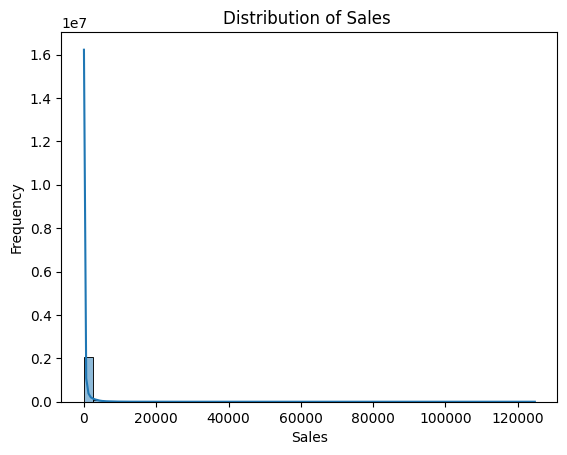

In [29]:
# Plot histogram

sns.histplot(train_processed['sales'], bins=50, kde=True)

plt.title('Distribution of Sales ')

plt.xlabel('Sales')

plt.ylabel('Frequency')

plt.show()

In [30]:
# transform sales to a new column sales log for less skewness

if 'sales_log' not in train_processed.columns:

    # Apply log transformation to handle skewness

    train_processed['sales_log'] = np.log1p(train_processed['sales'])

    print("'sales_log' column created using log transformation.")



# Define new target variable

y = train_processed['sales_log']



# Define feature set by dropping unnecessary columns

X = train_processed.drop(['id', 'date', 'sales', 'sales_log'], axis=1)

print("Defined target and feature sets.")

print(f"Features shape: {X.shape}")

print(f"Target shape: {y.shape}")

'sales_log' column created using log transformation.
Defined target and feature sets.
Features shape: (2182676, 13)
Target shape: (2182676,)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


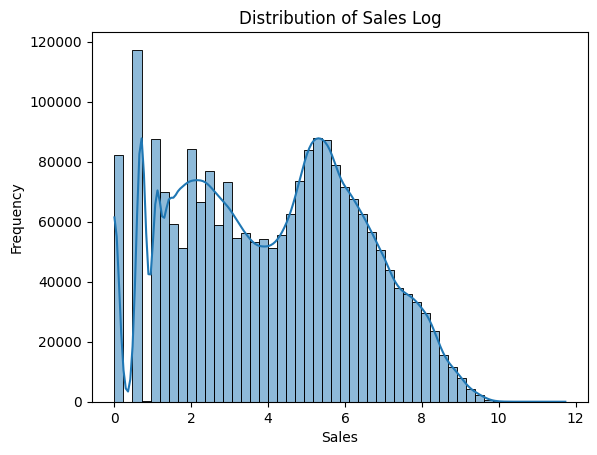

In [31]:
# Plot histogram for sales log

sns.histplot(train_processed['sales_log'], bins=50, kde=True)

plt.title('Distribution of Sales Log')

plt.xlabel('Sales')

plt.ylabel('Frequency')

plt.show()

In [32]:
### Split into Training and Validation Sets randomly because I removed the date column, only reserve day of week, month, year and lag features

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
X_train.isna().sum()

store_nbr            0
family               0
onpromotion          0
day_of_week          0
month                0
year                 0
transactions         0
dcoilwtico           0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64

In [34]:
X_val.isna().sum()

store_nbr            0
family               0
onpromotion          0
day_of_week          0
month                0
year                 0
transactions         0
dcoilwtico           0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64

### Model prediction

Random Forest Regressor:

- Là biến thể dành cho bài toán hồi quy của mô hình Random Forest. Mô hình Random Forest ứng dụng cách học Ensemble, tức là nó có sự tổng hợp kết quả dự đoán của các thành phần nhỏ hơn, ở đây là các Decision Tree, để đưa ra kết quả dự đoán cho đầu vào.
- Đối với Random Forest Regressor, là phiên bản dùng trong bài toán hồi quy, thì điểm khác so với Random Forest Classifier nằm ở cách tổng hợp quyết định. Nếu Classifier sẽ lấy nhãn có lượt vote cao nhất làm kết quả, thì Regressor sẽ lấy trung bình kết quả của các cây quyết định để làm kết quả
- Các tham số trong mô hình RandomForestRegressor của SKLearn:
    + n_estimators: Số cây được thuật toán xây dựng trước khi tổng hợp thông tin.
    + max_features: Max_features giới hạn số lượng để chọn các tính năng tối đa trong mỗi cây.

    + max_depth max_deep xác định số lần phân chia tối đa mà mỗi cây có thể thực hiện. :
     + random_state: giá trị để duy trì sự random ngẫu nhiên của thuật toán    + n_jobs: số vi xử lý có thể được dùng trong lúc train model, 1 là 1, -1 là vô số


##### RandomForestRegressor

In [35]:
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_val)

rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_rf))

mae_rf = mean_absolute_error(y_val, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.4f}")

print(f"Random Forest MAE: {mae_rf:.4f}")

Random Forest RMSE: 0.3909
Random Forest MAE: 0.2572


##### XGBoost

XGBoost:

- Đây cũng là 1 thuật toán Ensemble Learning, học tổng hợp từ các Decision Tree, và nó là 1 cải tiến cho Gradient Boosting.
- XGBoost có mục tiêu tổng quát hơn Random Forest, là cố gắng tìm ra những hệ số đủ tốt để fit toàn bộ dữ liệu vào 1 hàm tuyến tính.
- Quá trình tối ưu đó cũng dẫn đến tối ưu loss function. Và để tối ưu loss function, nó sử dụng nhiều cây quyết định được tạ ra một cách tuần tự.
- Bắt đầu từ một giá trị y dự đoán bất kỳ, ở mỗi bước, thuật toán sẽ tính residual giữa y dự đoán và y label dựa trên cây hiện tại, rồi tính toán dựa trên chỉ số Gain để ra được điểm phân chia và cách phân chia cho cây mới.
- Sau khi ra được cây mới, thuật toán tính toán và gộp thêm dự đoán của cây mới này vào dự đoán của mô hình, góp phần giảm sai sót cho mô hình so với lần học trước đó. Khi cộng gộp thì có sử dụng hệ số học learning rate.
- Cứ như vậy đến khi đạt số cây tối đa thì thuật toán dừng lại
- Tham số phổ biến thì cũng tương tự Random Forest vì cũng làm việc với các cây quyết định.
- Và ngoài ra nó có thêm các tham số như learning rate tương tự như gradient descent, để chỉ mức độ đóng góp của dự đoán của cây mới vào dự đoán mô hình tại mỗi bước, cũng giống như bước nhảy của thuật toán vậy.

In [36]:
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, 
                       max_depth=5, random_state=42, n_jobs=-1)

xgbr.fit(X_train, y_train)

y_pred_xgbr = xgbr.predict(X_val)

rmse_xgbr = np.sqrt(mean_squared_error(y_val, y_pred_xgbr))
mae_xgbr = mean_absolute_error(y_val, y_pred_xgbr)

print(f"XGBoost RMSE: {rmse_xgbr:.4f}")
print(f"XGBoost MAE: {mae_xgbr:.4f}")

XGBoost RMSE: 0.4409
XGBoost MAE: 0.2899


In [37]:
test_features = test_processed.drop(['id', 'date', 'sales', 'sales_log'], axis=1, errors='ignore')

# Ensure that test_features only contains feature columns
print("Columns in test_features:", test_features.columns.tolist())

Columns in test_features: ['store_nbr', 'family', 'onpromotion', 'day_of_week', 'month', 'year', 'transactions', 'dcoilwtico', 'sales_lag_1', 'sales_lag_7', 'sales_roll_mean_7', 'sales_roll_std_7', 'promo_last_7']


In [38]:
print(test_features.isnull().sum())

store_nbr            0
family               0
onpromotion          0
day_of_week          0
month                0
year                 0
transactions         0
dcoilwtico           0
sales_lag_1          0
sales_lag_7          0
sales_roll_mean_7    0
sales_roll_std_7     0
promo_last_7         0
dtype: int64


In [39]:
xgbr = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, 
                       max_depth=5, random_state=42, n_jobs=-1)

xgbr.fit(X, y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [42]:
# Make predictions on the test set
test_pred_log = xgbr.predict(test_features)

# Inverse the log transformation
test_pred = np.expm1(test_pred_log)

# Ensure no negative sales predictions
test_pred = np.where(test_pred < 0, 0, test_pred)

print("Predictions on the test set completed.")

Predictions on the test set completed.


In [43]:
# Create the submission DataFrame
submission = pd.DataFrame({
    'id': test_processed['id'],
    'sales': test_pred
})

# Save the submission to a CSV file
submission.to_csv('submission.csv', index=False)

# Display the first few rows of the submission file
print("Submission file 'submission.csv' created successfully:")
display(submission.head())

Submission file 'submission.csv' created successfully:


,id,sales
1684,3000888,2.583035
1685,3002670,0.000000
1686,3004452,0.000000
1687,3006234,0.067762
1688,3008016,0.022488
